In [1]:
import tensorflow as tf
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

The lines below open the story file and tokenize each word, removing punctutation.

In [2]:
lines = []
with open("The Last Question - Issac Asimov.txt") as f:
    lines = f.readlines()

In [3]:
for i in range(len(lines)):
    lines[i] = lines[i].strip('\n')

In [4]:
for i in range(len(lines)):
    lines[i] = lines[i].lower()

In [5]:
for i in range(len(lines)):
    lines[i] = re.sub(r'[^\w\s]','',lines[i])

In [6]:
tokens = []

for line in lines:
    for word in line.split():
        tokens.append(word)

In [7]:
tokens = list(set(tokens))
vocab_size = len(tokens)
vocab_size

1155

In [8]:
vocab, index = {}, 1

for token in tokens:
    vocab[token] = index
    
    index += 1

In [9]:
inverse_vocab = {index : token for token, index in vocab.items()}

In [10]:
story = []

for line in lines:
    for word in line.split():
        story.append(word)

In [11]:
encoded_story = [vocab[index] for index in story]

In [12]:
skip_grams = tf.keras.preprocessing.sequence.skipgrams(encoded_story, vocab_size, window_size = 3)

In [13]:
x_train, y_train = skip_grams[0], skip_grams[1]

In [14]:
x_train = np.array(x_train)

In [15]:
y_train = np.array(y_train)

In [16]:
word_model = tf.keras.Sequential()
word_model.add(tf.keras.layers.Input(1))
word_model.add(tf.keras.layers.Embedding(vocab_size, 128))
word_model.add(tf.keras.layers.Flatten())
word_model.summary()

context_model = tf.keras.Sequential()
context_model.add(tf.keras.layers.Input(1))
context_model.add(tf.keras.layers.Embedding(vocab_size, 128))
context_model.add(tf.keras.layers.Flatten())
context_model.summary()

merger = tf.keras.layers.Dot(axes=1)([word_model.inputs[0], context_model.inputs[0]])
merger = tf.keras.layers.Flatten()(merger)
merger = tf.keras.layers.Dense(1, activation = 'linear')(merger)
merger = tf.keras.layers.Dense(1, activation='sigmoid')(merger)
model = tf.keras.Model(inputs=[word_model.inputs, context_model.inputs], outputs=[merger])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 128)            147840    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
Total params: 147,840
Trainable params: 147,840
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 128)            147840    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
Total params: 147,840
Traina

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 1)            0           ['dot[0][0]']                

In [18]:
x_train[:, 0].reshape(-1, 1)

array([[ 611],
       [1038],
       [  32],
       ...,
       [ 309],
       [ 637],
       [ 378]])

In [19]:
x_train[:, 1].reshape(-1, 1)

array([[538],
       [681],
       [950],
       ...,
       [350],
       [702],
       [641]])

In [20]:
y_train.reshape(-1, 1)

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.09), loss='binary_crossentropy')

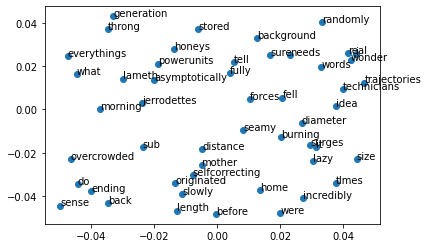

In [22]:
embeddings = np.array(word_model.layers[0].weights)
label = [inverse_vocab[i + 1] for i in range(1155)]

fig, ax = plt.subplots()
ax.scatter(embeddings[0, 0:50, 0], embeddings[0, 0:50, 1])

for i, txt in enumerate(label[:50]):
    ax.annotate(txt, (embeddings[0, :, 0][i], embeddings[0, :, 1][i]))

In [23]:
model.fit([x_train[:, 0].reshape(-1, 1), x_train[:, 1].reshape(-1, 1)], y_train.reshape(-1, 1), epochs=20)

Epoch 1/20
1711/1711 [==============================] - 3s 1ms/step - loss: 57333.1133
Epoch 2/20
1711/1711 [==============================] - 2s 1ms/step - loss: 37.4391
Epoch 3/20
1711/1711 [==============================] - 3s 1ms/step - loss: 40.8708
Epoch 4/20
1711/1711 [==============================] - 2s 1ms/step - loss: 40.0644
Epoch 5/20
1711/1711 [==============================] - 2s 1ms/step - loss: 36.9648
Epoch 6/20
1711/1711 [==============================] - 2s 1ms/step - loss: 30.2688
Epoch 7/20
1711/1711 [==============================] - 2s 1ms/step - loss: 16.4958
Epoch 8/20
1711/1711 [==============================] - 2s 1ms/step - loss: 3.0082
Epoch 9/20
1711/1711 [==============================] - 2s 1ms/step - loss: 0.7233
Epoch 10/20
1711/1711 [==============================] - 3s 1ms/step - loss: 0.6957
Epoch 11/20
1711/1711 [==============================] - 2s 1ms/step - loss: 0.6933
Epoch 12/20
1711/1711 [==============================] - 2s 1ms/step - loss

In [24]:
model.layers

In [25]:
model.layers[4].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.00025368]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-1.1883751], dtype=float32)>]

In [26]:
model([x_train[:, 0].reshape(-1, 1)[2], x_train[:, 1].reshape(-1, 1)[2]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4928418]], dtype=float32)>

In [27]:
word_model.weights

[<tf.Variable 'embedding/embeddings:0' shape=(1155, 128) dtype=float32, numpy=
 array([[-0.00030743, -0.04817745, -0.04834565, ..., -0.0132808 ,
         -0.03284314, -0.02626824],
        [ 0.04393623,  0.02550766, -0.02786427, ..., -0.0428059 ,
          0.04350765, -0.02833211],
        [ 0.04244024,  0.02266624,  0.03950239, ..., -0.01251163,
         -0.02946336,  0.03561704],
        ...,
        [-0.01783697, -0.02538698, -0.01393262, ...,  0.01220703,
         -0.04373911, -0.02806847],
        [-0.04877501,  0.02607169,  0.032695  , ...,  0.03480997,
          0.04316065,  0.01052675],
        [ 0.01307703,  0.02440323, -0.01182229, ..., -0.03950926,
          0.00259678,  0.04988021]], dtype=float32)>]

In [28]:
context_model.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(1155, 128) dtype=float32, numpy=
 array([[ 0.03788645,  0.02178668,  0.0056882 , ..., -0.01825662,
          0.03416112,  0.04797621],
        [-0.03209426,  0.03232273,  0.02154578, ..., -0.02447411,
          0.03866137,  0.00377929],
        [ 0.04348965, -0.04358894, -0.02523109, ..., -0.00865107,
          0.00162745, -0.02585   ],
        ...,
        [-0.03650104,  0.01638366,  0.04801494, ...,  0.03564889,
         -0.04858321,  0.03909859],
        [-0.03653598,  0.04441366, -0.02083086, ..., -0.02511324,
         -0.03277122,  0.03377498],
        [ 0.02574165,  0.04056272, -0.00027223, ...,  0.02313768,
          0.04207077,  0.03740401]], dtype=float32)>]

In [29]:
model.layers[4].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.00025368]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([-1.1883751], dtype=float32)>]

In [30]:
word_encodings = (tf.keras.layers.Dot(axes = 1)([word_model.weights[0], context_model.weights[0]])) + model.layers[4].weights[1]

In [31]:
word_encodings = np.array(word_encodings)

In [32]:
len(tokens)

1155

In [33]:
word_encodings

array([[-1.1777216],
       [-1.1806778],
       [-1.1990241],
       ...,
       [-1.1887832],
       [-1.1739506],
       [-1.1841803]], dtype=float32)

In [34]:
word_encoding = {tokens[i] : word_encodings[i][0] for i in range(1155)}

In [35]:
word_encoding

{'before': -1.1777216,
 'i': -1.1806778,
 'wonder': -1.1990241,
 'words': -1.1844145,
 'idea': -1.1963744,
 'tell': -1.1940349,
 'needs': -1.1936293,
 'jerrodettes': -1.1870584,
 'powerunits': -1.1834167,
 'seamy': -1.1914309,
 'burning': -1.1792895,
 'background': -1.1948465,
 'mother': -1.1996576,
 'generation': -1.1886494,
 'sense': -1.1843793,
 'home': -1.1918054,
 'back': -1.1890568,
 'fell': -1.1958756,
 'do': -1.190574,
 'technicians': -1.200197,
 'sub': -1.1734953,
 'real': -1.2171433,
 'lazy': -1.2172865,
 'what': -1.1718678,
 'surges': -1.1692063,
 'were': -1.1921456,
 'fully': -1.1929878,
 'lameth': -1.202154,
 'throng': -1.1881711,
 'ending': -1.181129,
 'originated': -1.1793622,
 'it': -1.1913761,
 'sure': -1.1986369,
 'stored': -1.1865826,
 'diameter': -1.205085,
 'morning': -1.1769394,
 'everythings': -1.2068528,
 'overcrowded': -1.1679984,
 'asymptotically': -1.1898981,
 'selfcorrecting': -1.200931,
 'tlmes': -1.1838921,
 'slowly': -1.1909398,
 'randomly': -1.1940072,
 

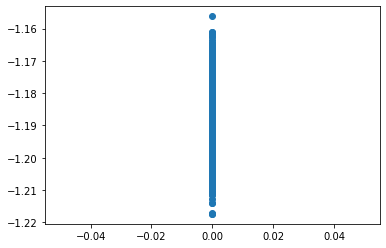

In [36]:
plt.scatter(tf.zeros((1, word_encodings[:].shape[0])), word_encodings[:])

In [37]:
tf.zeros((1, word_encodings[:].shape[0]))[:, 10]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

<Figure size 720x288 with 0 Axes>

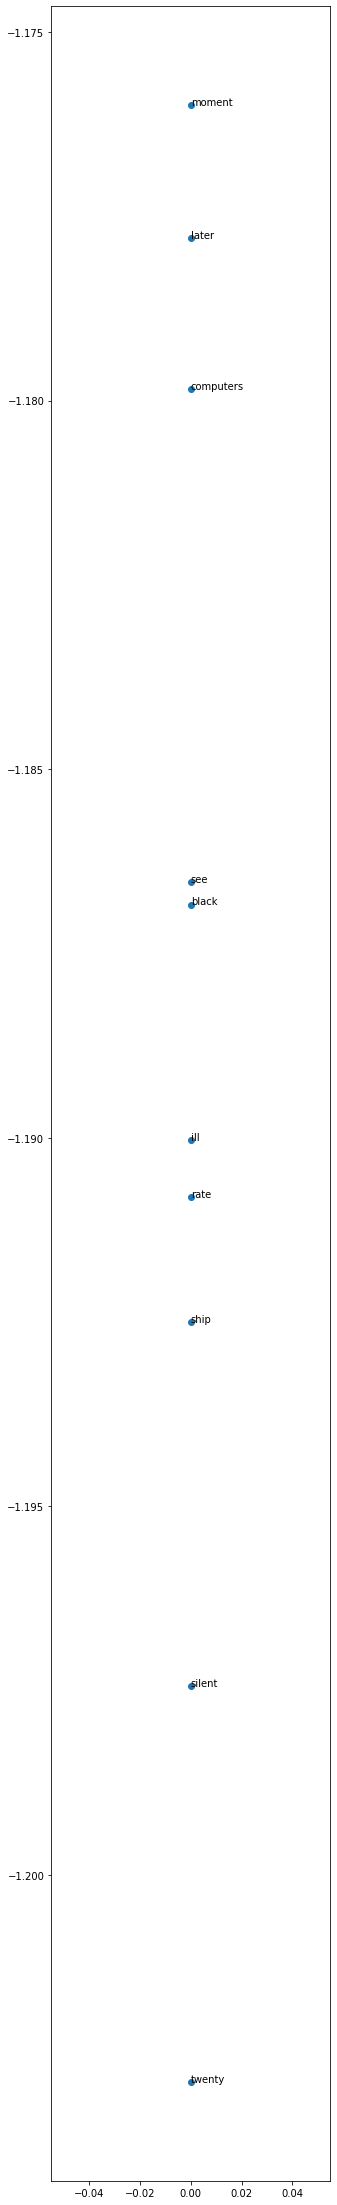

<Figure size 432x288 with 0 Axes>

In [38]:
%matplotlib inline
plt.figure(figsize=(10,4))
start, end = 650, 660
fig, ax = plt.subplots(figsize=(5,40))
ax.scatter(tf.zeros((1, word_encodings[start:end].shape[0])), word_encodings[start:end])

for i, txt in enumerate(tokens[start:end]):
    ax.annotate(txt, (tf.zeros((1, word_encodings[start:end].shape[0]))[:10,i], word_encodings[start:end][i]))
plt.show()
plt.savefig('foo.pdf')

In [39]:
word_encoding

{'before': -1.1777216,
 'i': -1.1806778,
 'wonder': -1.1990241,
 'words': -1.1844145,
 'idea': -1.1963744,
 'tell': -1.1940349,
 'needs': -1.1936293,
 'jerrodettes': -1.1870584,
 'powerunits': -1.1834167,
 'seamy': -1.1914309,
 'burning': -1.1792895,
 'background': -1.1948465,
 'mother': -1.1996576,
 'generation': -1.1886494,
 'sense': -1.1843793,
 'home': -1.1918054,
 'back': -1.1890568,
 'fell': -1.1958756,
 'do': -1.190574,
 'technicians': -1.200197,
 'sub': -1.1734953,
 'real': -1.2171433,
 'lazy': -1.2172865,
 'what': -1.1718678,
 'surges': -1.1692063,
 'were': -1.1921456,
 'fully': -1.1929878,
 'lameth': -1.202154,
 'throng': -1.1881711,
 'ending': -1.181129,
 'originated': -1.1793622,
 'it': -1.1913761,
 'sure': -1.1986369,
 'stored': -1.1865826,
 'diameter': -1.205085,
 'morning': -1.1769394,
 'everythings': -1.2068528,
 'overcrowded': -1.1679984,
 'asymptotically': -1.1898981,
 'selfcorrecting': -1.200931,
 'tlmes': -1.1838921,
 'slowly': -1.1909398,
 'randomly': -1.1940072,
 

In [40]:
word_sorted_encoding = sorted(word_encoding.items(), key=lambda x: x[1])

In [41]:
word_sorted_encoding

[('planetary', -1.2173736),
 ('lazy', -1.2172865),
 ('real', -1.2171433),
 ('finally', -1.2140901),
 ('necessary', -1.2140836),
 ('pass', -1.2126446),
 ('confidently', -1.2113959),
 ('constructed', -1.2112231),
 ('zee', -1.2111998),
 ('galactic', -1.2108381),
 ('must', -1.2103188),
 ('computing', -1.2095635),
 ('residence', -1.2091236),
 ('shrugged', -1.2089721),
 ('managed', -1.2085474),
 ('lest', -1.2085466),
 ('grasp', -1.2085458),
 ('for', -1.2083805),
 ('directly', -1.2083396),
 ('answered', -1.2079383),
 ('little', -1.2079179),
 ('microvac', -1.2077905),
 ('centered', -1.2077358),
 ('snapped', -1.2076356),
 ('circling', -1.2076324),
 ('tremendous', -1.2074767),
 ('printed', -1.2074485),
 ('shrank', -1.2073199),
 ('let', -1.2071127),
 ('everythings', -1.2068528),
 ('an', -1.2066946),
 ('momentary', -1.2066127),
 ('both', -1.2064241),
 ('progression', -1.2059759),
 ('answers', -1.2058729),
 ('agitated', -1.2054068),
 ('question', -1.2053088),
 ('dregs', -1.2051741),
 ('diameter', -

In [42]:
len(word_sorted_encoding)

1155

In [43]:
word2vec = {}

for i in range(len(word_sorted_encoding)):
    word2vec[word_sorted_encoding[i][0]] = i

In [44]:
word2vec

{'planetary': 0,
 'lazy': 1,
 'real': 2,
 'finally': 3,
 'necessary': 4,
 'pass': 5,
 'confidently': 6,
 'constructed': 7,
 'zee': 8,
 'galactic': 9,
 'must': 10,
 'computing': 11,
 'residence': 12,
 'shrugged': 13,
 'managed': 14,
 'lest': 15,
 'grasp': 16,
 'for': 17,
 'directly': 18,
 'answered': 19,
 'little': 20,
 'microvac': 21,
 'centered': 22,
 'snapped': 23,
 'circling': 24,
 'tremendous': 25,
 'printed': 26,
 'shrank': 27,
 'let': 28,
 'everythings': 29,
 'an': 30,
 'momentary': 31,
 'both': 32,
 'progression': 33,
 'answers': 34,
 'agitated': 35,
 'question': 36,
 'dregs': 37,
 'diameter': 38,
 'immortal': 39,
 'clumsy': 40,
 'being': 41,
 'thin': 42,
 'could': 43,
 'explosion': 44,
 'zero': 45,
 'tree': 46,
 'two': 47,
 'forgetting': 48,
 'weak': 49,
 'after': 50,
 'out': 51,
 'admit': 52,
 'dimming': 53,
 'guided': 54,
 'quiet': 55,
 'giant': 56,
 'itll': 57,
 'collect': 58,
 'whatever': 59,
 'bert': 60,
 'snuffed': 61,
 'adell': 62,
 'springing': 63,
 'massively': 64,
 'a

In [45]:
inverse_vec = {index : word for word, index in word2vec.items()}

In [46]:
inverse_vec

{0: 'planetary',
 1: 'lazy',
 2: 'real',
 3: 'finally',
 4: 'necessary',
 5: 'pass',
 6: 'confidently',
 7: 'constructed',
 8: 'zee',
 9: 'galactic',
 10: 'must',
 11: 'computing',
 12: 'residence',
 13: 'shrugged',
 14: 'managed',
 15: 'lest',
 16: 'grasp',
 17: 'for',
 18: 'directly',
 19: 'answered',
 20: 'little',
 21: 'microvac',
 22: 'centered',
 23: 'snapped',
 24: 'circling',
 25: 'tremendous',
 26: 'printed',
 27: 'shrank',
 28: 'let',
 29: 'everythings',
 30: 'an',
 31: 'momentary',
 32: 'both',
 33: 'progression',
 34: 'answers',
 35: 'agitated',
 36: 'question',
 37: 'dregs',
 38: 'diameter',
 39: 'immortal',
 40: 'clumsy',
 41: 'being',
 42: 'thin',
 43: 'could',
 44: 'explosion',
 45: 'zero',
 46: 'tree',
 47: 'two',
 48: 'forgetting',
 49: 'weak',
 50: 'after',
 51: 'out',
 52: 'admit',
 53: 'dimming',
 54: 'guided',
 55: 'quiet',
 56: 'giant',
 57: 'itll',
 58: 'collect',
 59: 'whatever',
 60: 'bert',
 61: 'snuffed',
 62: 'adell',
 63: 'springing',
 64: 'massively',
 65